In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, matthews_corrcoef, balanced_accuracy_score, f1_score, accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE , ADASYN, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Load dataset
df = pd.read_csv(r'F:\university\UniVR\Courses\ML\project\data.csv', delimiter=';')
df.rename(columns={'Nacionality': 'Nationality','Daytime/evening attendance\t': 'Daytime/evening attendance'}, inplace=True) 


categorical_cols = ['Marital status', 'Application mode', 'Course', 'Previous qualification', 
                    "Nationality", "Mother's qualification", "Father's qualification", 
                    "Mother's occupation", "Father's occupation"]

continuous_cols = [
    'Previous qualification (grade)', 'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate', 'Inflation rate', 'GDP'
]

# Convert categorical features
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Convert binary features
binary_cols = ['Daytime/evening attendance', 'Displaced', 'Educational special needs', 
               'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']
for col in binary_cols:
    df[col] = df[col].astype(bool)

# Ordinal column
ordinal_cols = ['Application order']

#target column
target_col = 'Target'



Class Imbalance DataFrame:
           Count  Proportion
Target                     
Graduate   2209    0.499322
Dropout    1421    0.321203
Enrolled    794    0.179476

Imbalance ratio (max/min): 2.78


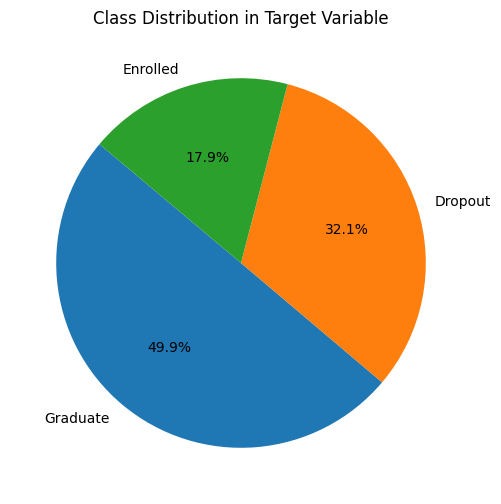

In [4]:
# Calculate imbalance ratio -- ratio of most common to least common
class_counts = df['Target'].value_counts()
class_proportions = df['Target'].value_counts(normalize=True)

class_im_df = pd.concat([class_counts, class_proportions], axis=1)
class_im_df.columns = ['Count', 'Proportion']
print("\nClass Imbalance DataFrame:\n", class_im_df)

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")

plt.figure(figsize=(10, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in Target Variable')  
plt.show()

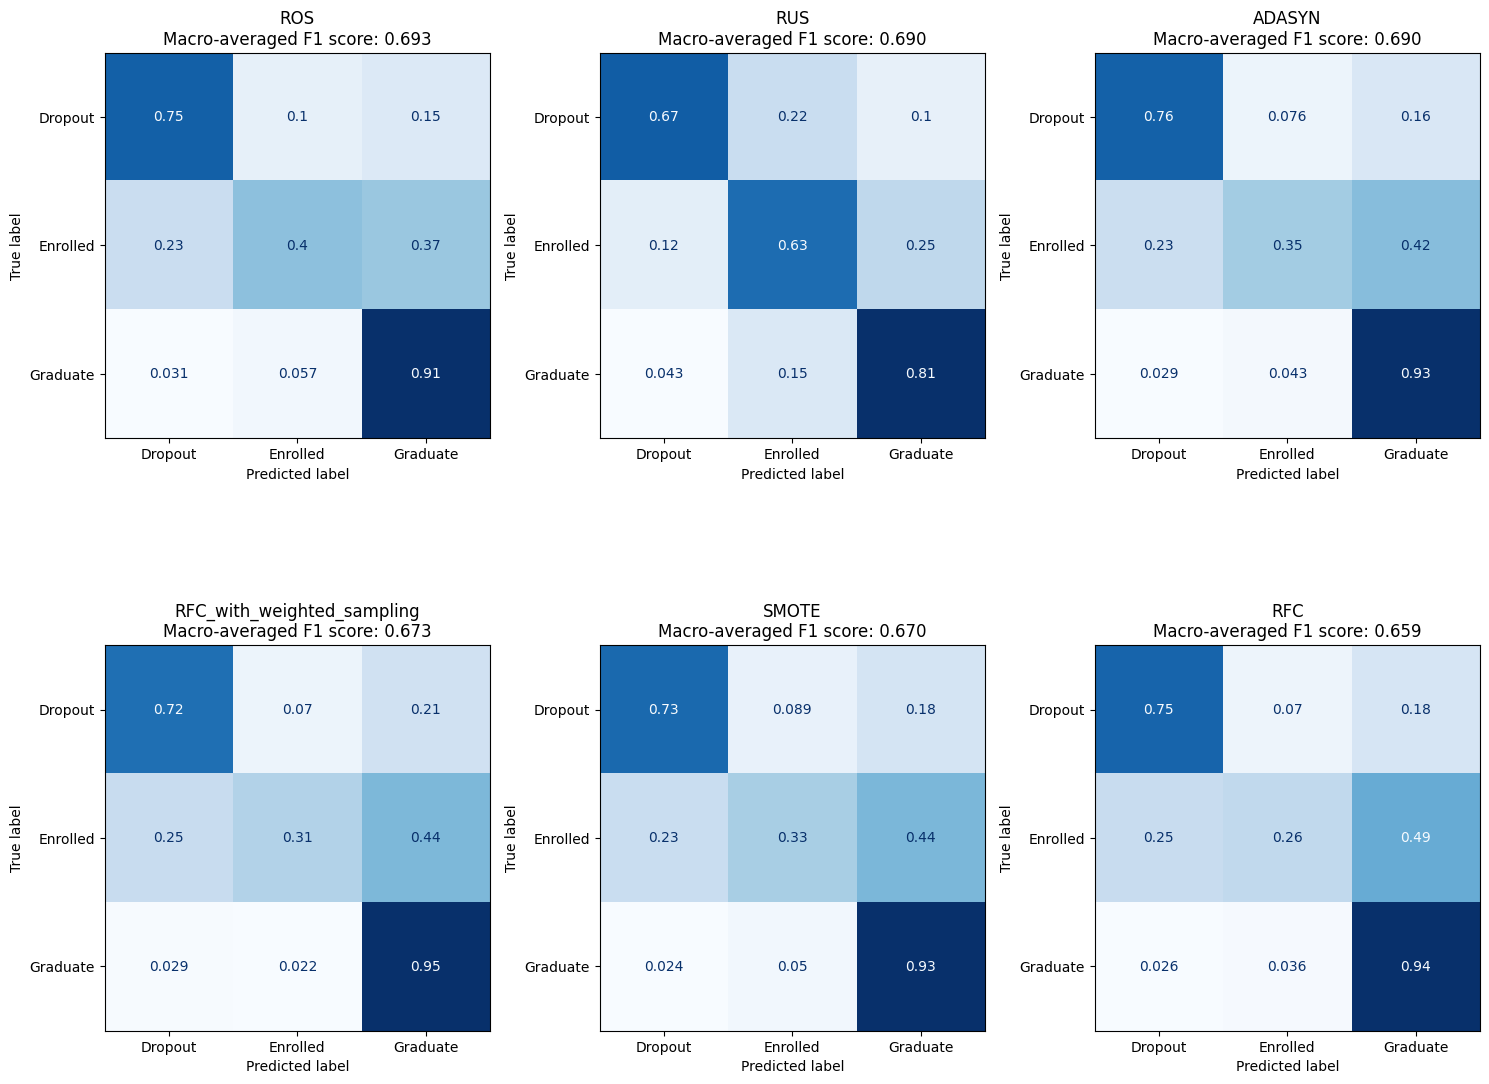

In [ ]:
# Prepare data for modeling       
X = df.drop(columns=[target_col])
y = df[target_col]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train0, X_test, y_train0, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Model_names = ['RFC', 'RFC_with_weighted_sampling', 'SMOTE', 'ROS', 'RUS', 'ADASYN']

all_results = []

# Set up column transformer for encoding
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough')

# Build pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))])  

for model in Model_names:
    if model == 'RFC':
        X_train = X_train0
        y_train = y_train0

    elif model == 'SMOTE':
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train, y_train = smote.fit_resample(X_train0, y_train0)
    elif model == 'ROS':
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train0, y_train0)
    elif model == 'RUS':
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train0, y_train0)
    elif model == 'ADASYN':
        adasyn = ADASYN(random_state=42)
        X_train, y_train = adasyn.fit_resample(X_train0, y_train0)
        

    if  model == 'RFC_with_weighted_sampling':
        sample_weights = compute_sample_weight(class_weight="balanced", y=y_train0)
        pipeline.fit(X_train0, y_train0, clf__sample_weight=sample_weights)
        y_pred = pipeline.predict(X_test) 
    else:  
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
    # Store results
    all_results.append({
           "type": model,
            "macro_averaged_F1_score": f1_score(y_test, y_pred, average='macro'),
            "confusion_matrix": confusion_matrix(y_test, y_pred, normalize='true'),
        })

n_models = len(all_results)
n_cols = int(np.ceil(np.sqrt(n_models)))
n_rows = int(np.ceil(n_models / n_cols))

df_results = pd.DataFrame(all_results).sort_values("macro_averaged_F1_score", ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten() 

for idx, result in df_results.iterrows():    
    disp = ConfusionMatrixDisplay(confusion_matrix=result["confusion_matrix"], display_labels=le.classes_)
    disp.plot(ax=axes[idx], colorbar=False, cmap='Blues')
    axes[idx].set_title(f'{result["type"]}\nMacro-averaged F1 score: {result["macro_averaged_F1_score"]:.3f}')

    
# Hide empty subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


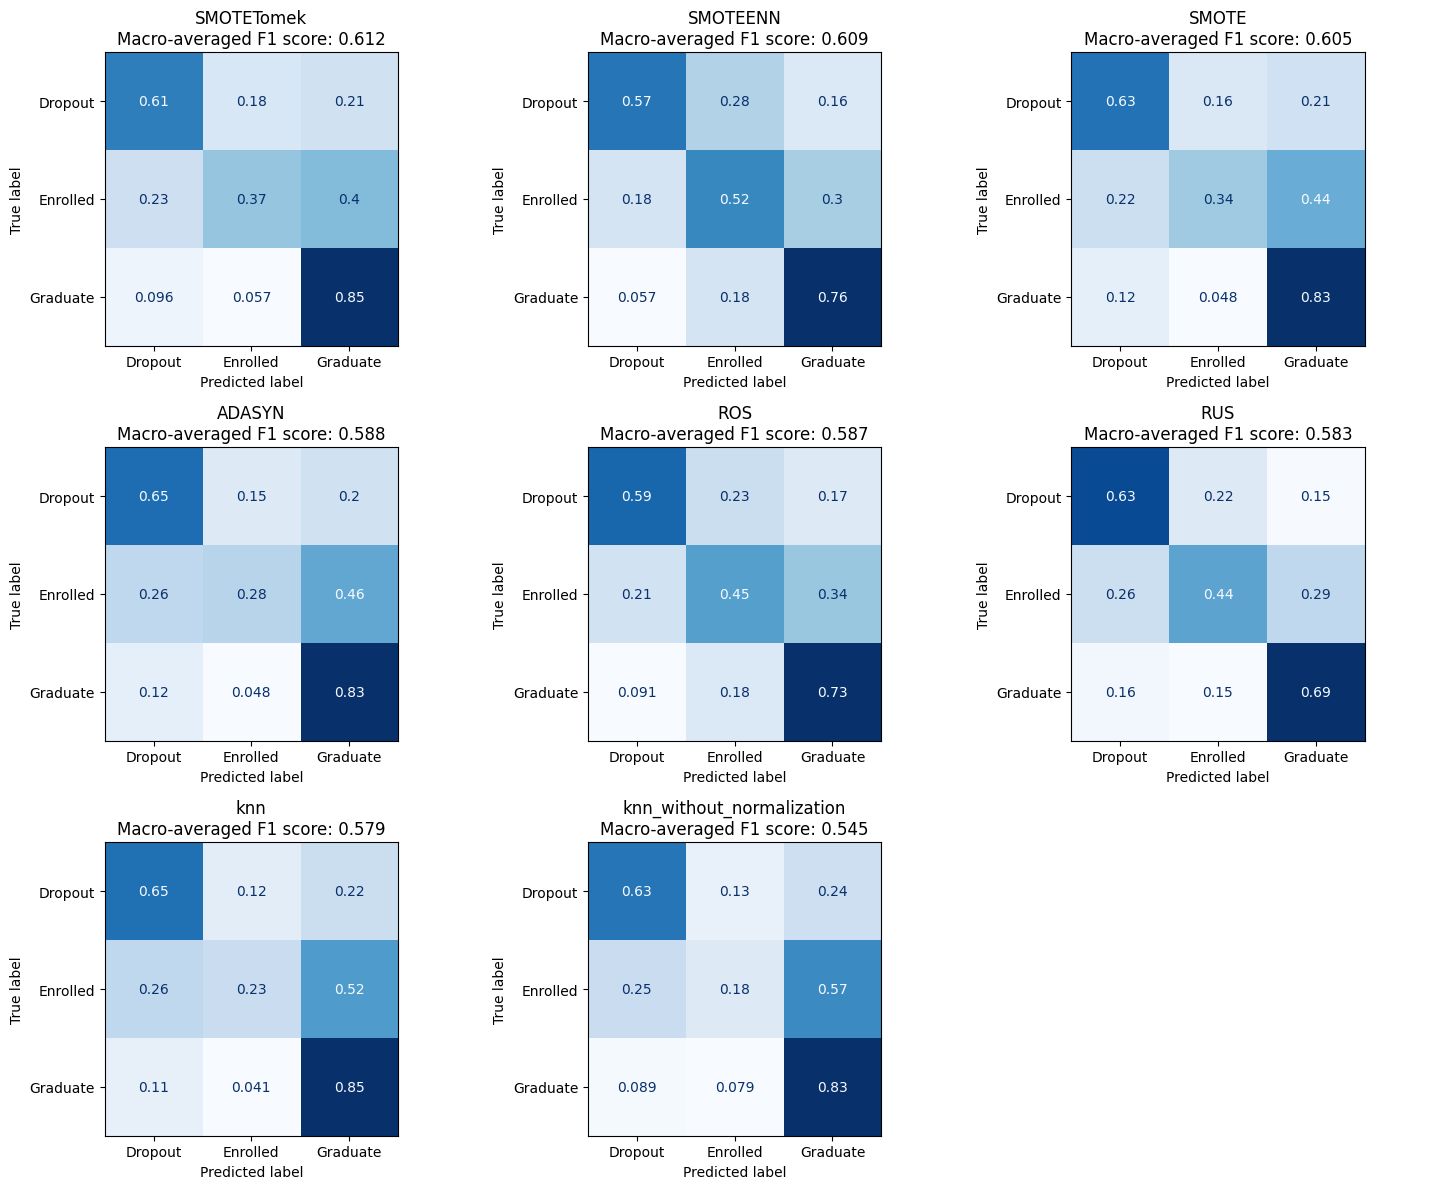

In [ ]:
# KNN Classifier with different sampling methods
all_results_knn=[]

###
preprocessor_knn = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough')

pipeline_knn = Pipeline([
    ('preprocess', preprocessor_knn),
    ('clf', KNeighborsClassifier(n_neighbors=3))])

pipeline_knn.fit(X_train0, y_train0)
y_pred = pipeline_knn.predict(X_test)

all_results_knn.append({
            "type": "knn_without_normalization",
            "macro_averaged_F1_score": f1_score(y_test, y_pred, average='macro'),
            "confusion_matrix": confusion_matrix(y_test, y_pred, normalize='true'),
            })
###

preprocessor_knn = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('cont', StandardScaler(), continuous_cols + ordinal_cols)],
    remainder='passthrough')


pipeline_knn = Pipeline([
    ('preprocess', preprocessor_knn),
    ('clf', KNeighborsClassifier(n_neighbors=3))])

Model_names_knn = ['knn', 'SMOTE', 'ROS', 'RUS', 'ADASYN', 'SMOTETomek', 'SMOTEENN']
for model in Model_names_knn:
    if model == 'knn':
        X_train = X_train0
        y_train = y_train0
    elif model == 'SMOTE':
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train, y_train = smote.fit_resample(X_train0, y_train0)
    elif model == 'ROS':
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train0, y_train0)
    elif model == 'RUS':
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train0, y_train0)
    elif model == 'ADASYN':
        adasyn = ADASYN(random_state=42)
        X_train, y_train = adasyn.fit_resample(X_train0, y_train0)
    elif model == 'SMOTETomek': 
        smotetomek = SMOTETomek( random_state=42)
        X_train, y_train = smotetomek.fit_resample(X_train0, y_train0)
    elif model == 'SMOTEENN':
        smoteenn = SMOTEENN( random_state=42)
        X_train, y_train = smoteenn.fit_resample(X_train0, y_train0)

    pipeline_knn.fit(X_train, y_train)
    y_pred = pipeline_knn.predict(X_test)
    
    # Store results
    all_results_knn.append({
            "type": model,
            "macro_averaged_F1_score": f1_score(y_test, y_pred, average='macro'),
            "confusion_matrix": confusion_matrix(y_test, y_pred, normalize='true'),
            })


n_models = len(all_results_knn)
n_cols = int(np.ceil(np.sqrt(n_models)))
n_rows = int(np.ceil(n_models / n_cols))

df_results_knn = pd.DataFrame(all_results_knn).sort_values("macro_averaged_F1_score", ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten() 

for idx, result in df_results_knn.iterrows():
    disp = ConfusionMatrixDisplay(confusion_matrix=result["confusion_matrix"], display_labels=le.classes_)
    disp.plot(ax=axes[idx], colorbar=False, cmap='Blues')
    axes[idx].set_title(f'{result["type"]}\nMacro-averaged F1 score: {result["macro_averaged_F1_score"]:.3f}')

for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()